In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
%matplotlib inline
import time
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
import glob
from skimage.feature import hog

In [2]:
def visualize_images(input_images, num_cols, figure_name, cmap = None):
    "Shows input images by stacking them in num_cols columns"
    fig, axes = plt.subplots((int)((len(input_images) + 1) /num_cols), num_cols, figsize=(24, 20))

    fig = plt.gcf()
    fig.canvas.manager.set_window_title(figure_name)
    
    print(figure_name)
    
    for ax, image in zip(axes.flat, input_images):
        if(cmap == "gray" or cmap == 'hot'):
            ax.imshow(image, cmap=cmap)
        elif(image.shape[2]==1):
            ax.imshow(image[:,:,0], cmap = cmap)
        else:
            ax.imshow(image, cmap=cmap)

    plt.show()

In [3]:
vehicles_dir =     './vehicles/'
non_vehicles_dir = './non-vehicles/'

# images are divided up into vehicles and non-vehicles
cars = []
notcars = []

# Read vehicle images
images = glob.iglob(vehicles_dir + '/**/*.png', recursive=True)

for image in images:
        cars.append(image)
        
# Read non-vehicle images
images = glob.iglob(non_vehicles_dir + '/**/*.png', recursive=True)

for image in images:
        notcars.append(image)

In [4]:
def convert_color(img, conv='RGB2YCrCb'):
    """
    Convert the image from one color space to the other
    """
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if conv == 'Gray':
        return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

Text(0.5, 1.0, 'YUV')

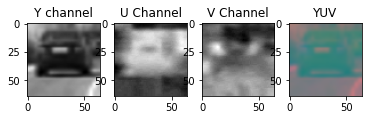

In [5]:
car = plt.imread(cars[1])
notcar = plt.imread(notcars[1])

fig = plt.figure()
plt.subplot(141)
yuv_image = convert_color(car, 'RGB2YUV')
plt.imshow(yuv_image[:,:,0], cmap ="gray")
plt.title('Y channel')
plt.subplot(142)
plt.imshow(yuv_image[:,:,1], cmap ="gray")
plt.title('U Channel')
plt.subplot(143)
plt.imshow(yuv_image[:,:,2], cmap ="gray")
plt.title('V Channel')
plt.subplot(144)
plt.imshow(yuv_image)
plt.title('YUV')

In [6]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    """
    Return the hog features of the given input image
    Call with two outputs if vis==True"""
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualize=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualize=vis, feature_vector=feature_vec)
        return features

Text(0.5, 1.0, 'not car HOG Visualization')

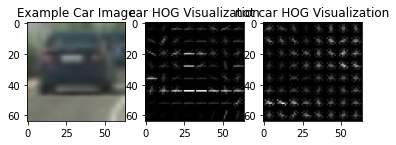

In [7]:
orient = 9
pix_per_cell = 8
cell_per_block = 2

car_features, hog_image = get_hog_features(cv2.cvtColor(car, cv2.COLOR_RGB2GRAY), orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)

notcar_features, notcar_hog_image = get_hog_features(cv2.cvtColor(notcar, cv2.COLOR_RGB2GRAY), orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)

# Plot the examples
fig = plt.figure()
plt.subplot(131)
plt.imshow(car)
plt.title('Example Car Image')
plt.subplot(132)
plt.imshow(hog_image, cmap='gray')
plt.title('car HOG Visualization')
plt.subplot(133)
plt.imshow(notcar_hog_image, cmap='gray')
plt.title('not car HOG Visualization')

In [8]:
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2):

    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        image = (image * 255).astype(np.uint8)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
        

        # Call get_hog_features() with vis=False, feature_vec=True
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)   

        # Append the new feature vector to the features list
        file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features


In [9]:
# Train

colorspace = 'YUV'
orient = 9
pix_per_cell = 8
cell_per_block = 2
spatial_size=(32, 32)
hist_bins=32

t=time.time()

car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block)
notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64) 

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)

# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.15, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC X_scaler
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

126.22 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5292
13.06 Seconds to train SVC...


E:\anaconda\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [10]:
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Test Accuracy of SVC =  0.9865
My SVC predicts:  [0. 0. 0. 1. 1. 1. 0. 0. 0. 1.]
For these 10 labels:  [0. 0. 0. 1. 1. 1. 0. 0. 0. 1.]
0.001 Seconds to predict 10 labels with SVC


In [11]:
#Save the model

import pickle

# Save the model
data_file = 'svc_pickle.sav'
pickle.dump(
            {
                'svc': svc,
                'scaler': X_scaler,
                'orient': orient,
                'pix_per_cell': pix_per_cell,
                'cell_per_block': cell_per_block,
                'spatial_size': spatial_size,
                'hist_bins': hist_bins

            },
            open(data_file, 'wb'))
print(f'Model has been saved to {data_file}')

Model has been saved to svc_pickle.sav


In [12]:
# Load the model
import pickle

def load(data_file):
    dist_pickle = pickle.load(open(f"{data_file}", "rb" ))
    return dist_pickle

data_file = './svc_pickle.sav'
dist_pickle = load(data_file)
print(dist_pickle)
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]

{'svc': LinearSVC(), 'scaler': StandardScaler(), 'orient': 9, 'pix_per_cell': 8, 'cell_per_block': 2, 'spatial_size': (32, 32), 'hist_bins': 32}


In [13]:
test_images_dir = './test_images/'

test_images = []

images = glob.glob(test_images_dir + '*.jpg')

for image in images:
        test_images.append(mpimg.imread(image))

In [14]:
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, vis_bboxes = False):
    
    draw_img = np.copy(img)
    xstart = int(img.shape[1]/5)
    xstop = img.shape[1]
    img_tosearch = img[ystart:ystop, xstart:xstop,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YUV')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (int(imshape[1]/scale), int(imshape[0]/scale)))

    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    rectangles = []

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3)).reshape(1, -1)

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            test_features = X_scaler.transform(hog_features)   
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1 or vis_bboxes == True:
                xbox_left = int(xleft*scale)
                ytop_draw = int(ytop*scale)
                win_draw = int(window*scale)
                rectangles.append(((xbox_left+xstart, ytop_draw+ystart),(xbox_left+win_draw+xstart,ytop_draw+win_draw+ystart)))
                              
    return rectangles

In [15]:
def get_rectangles(image, scales = [1, 1.5, 2, 2.5, 3], 
                   ystarts = [400, 400, 450, 450, 460], 
                   ystops = [528, 550, 620, 650, 700]):
    global svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins

    out_rectangles = []
    for scale, ystart, ystop in zip(scales, ystarts, ystops):
        rectangles = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        if len(rectangles) > 0:
            out_rectangles.append(rectangles)
    out_rectangles = [item for sublist in out_rectangles for item in sublist] 
    return out_rectangles

In [16]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

In [17]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [18]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    img_copy = np.copy(img)
    result_rectangles = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        area = (bbox[1][1] - bbox[0][1]) * (bbox[1][0] - bbox[0][0])
        if area > 40 * 40:
            result_rectangles.append(bbox)
            # Draw the box on the image
            cv2.rectangle(img_copy, bbox[0], bbox[1], (0,255,0), 6)
    # Return the image
    return result_rectangles, img_copy

In [19]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [20]:
def visualize_bboxes(image, scales = [1, 1.5, 2, 2.5, 3], 
                   ystarts = [400, 400, 450, 450, 460], 
                   ystops = [528, 550, 620, 650, 700]):
    out_rectangles = []
    for scale, ystart, ystop in zip(scales, ystarts, ystops):
        rectangles = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, vis_bboxes = True)
        if len(rectangles) > 0:
            out_rectangles.append(rectangles)
    out_rectangles = [item for sublist in out_rectangles for item in sublist] 

    plt.figure(figsize=(20,10))
    plt.imshow(draw_boxes(image, out_rectangles, color='random', thick=3))

0.7633192539215088


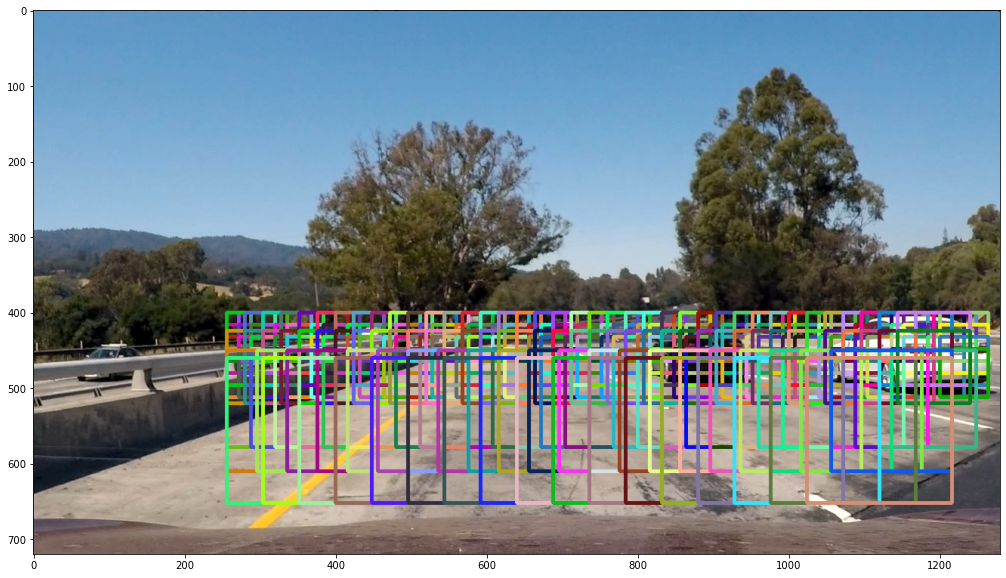

In [21]:
import time
t = time.time()
visualize_bboxes(test_images[0])
print(time.time() - t)

In [22]:
from scipy.ndimage import label

result_images = []
result_boxes = []
heatmap_images = []
result_img_all_boxes = []
for test_image in test_images:
    rectangles = get_rectangles(test_image)
    result_img_all_boxes.append(draw_boxes(test_image, rectangles, color='random', thick=3))
    heatmap_image = np.zeros_like(test_image[:, :, 0])
    heatmap_image = add_heat(heatmap_image, rectangles)
    heatmap_images.append(heatmap_image)
    heatmap_image = apply_threshold(heatmap_image, 2)
    labels = label(heatmap_image)
    rectangles, result_image = draw_labeled_bboxes(test_image, labels)
    result_boxes.append(rectangles)
    result_images.append(result_image)

test


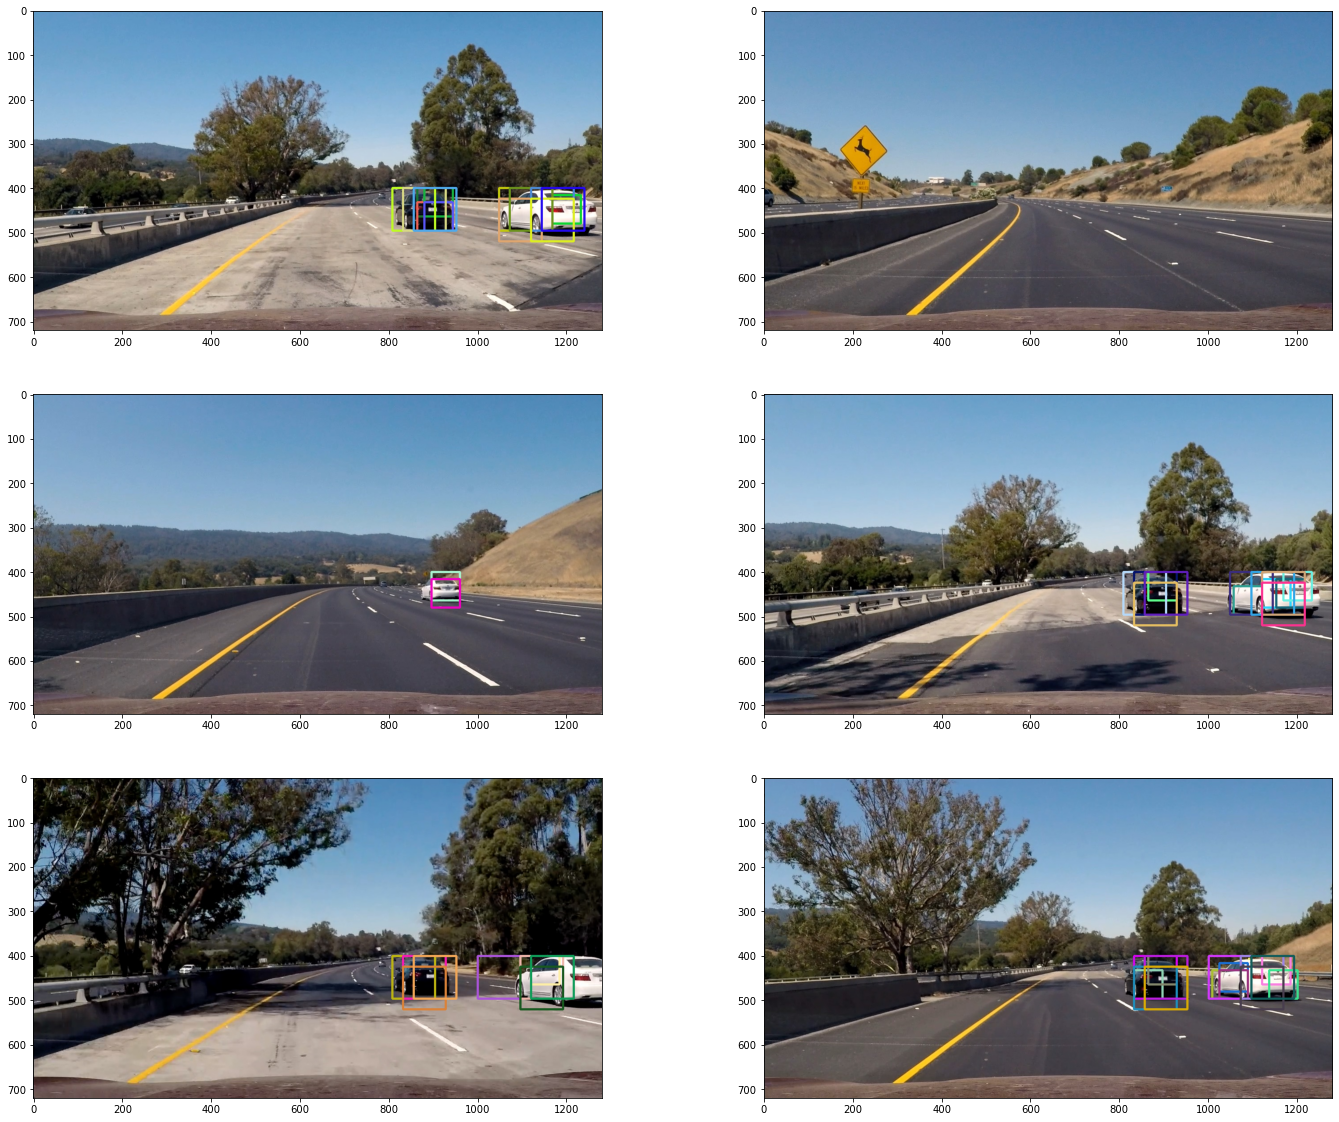

In [23]:
visualize_images(result_img_all_boxes, 2, "test")

test


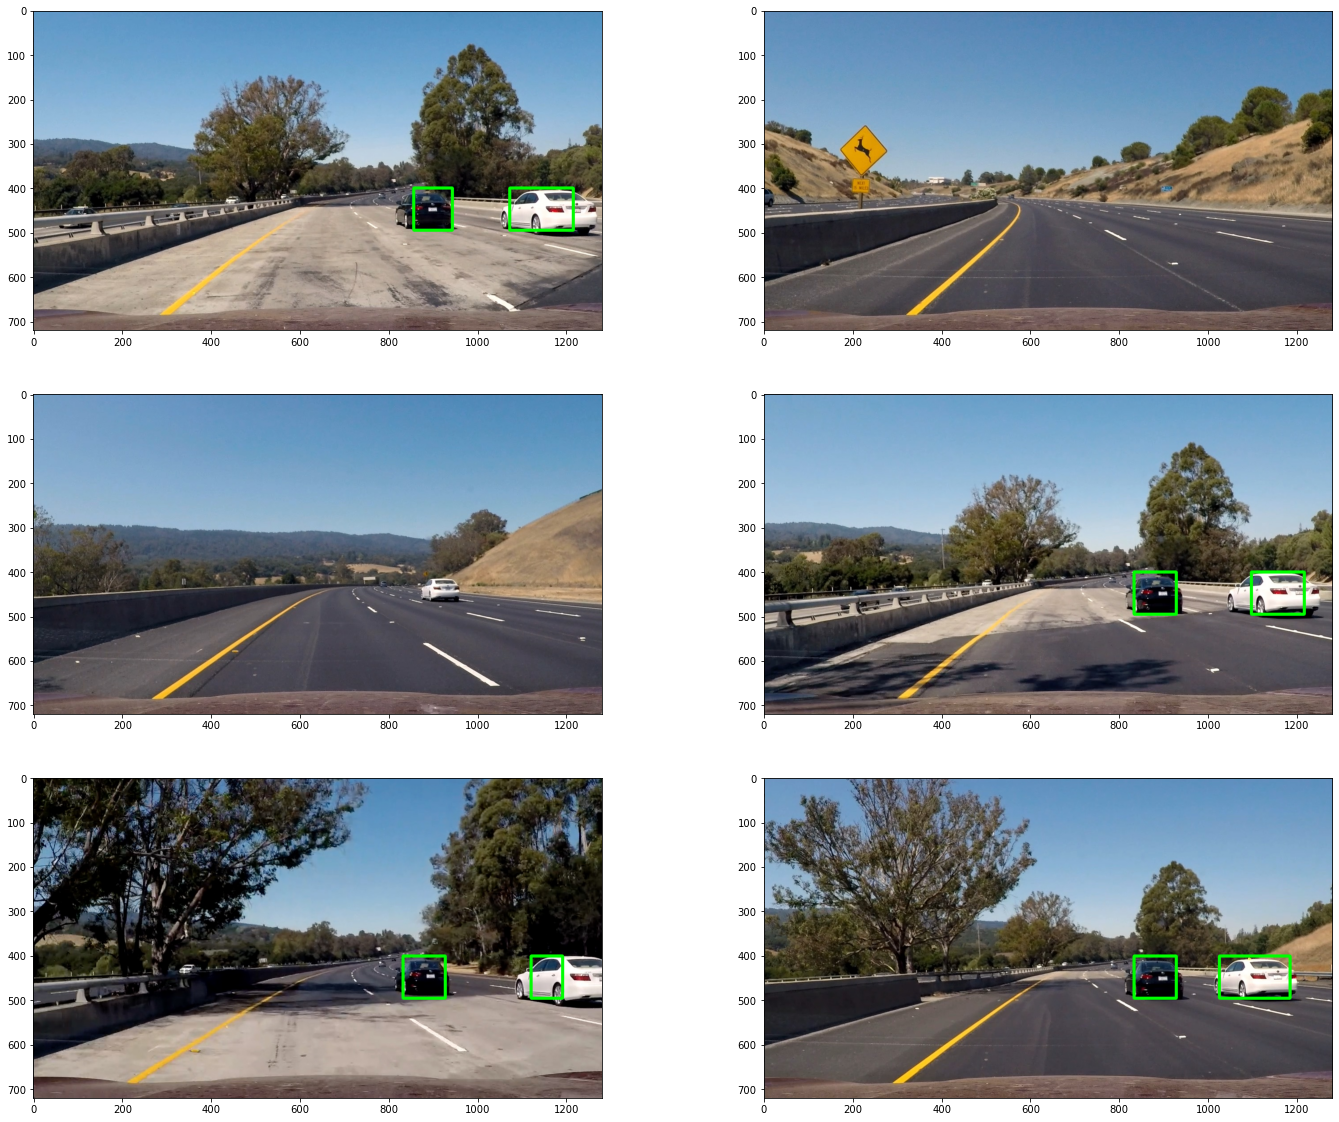

In [24]:
visualize_images(result_images, 2, "test")

Heatmap


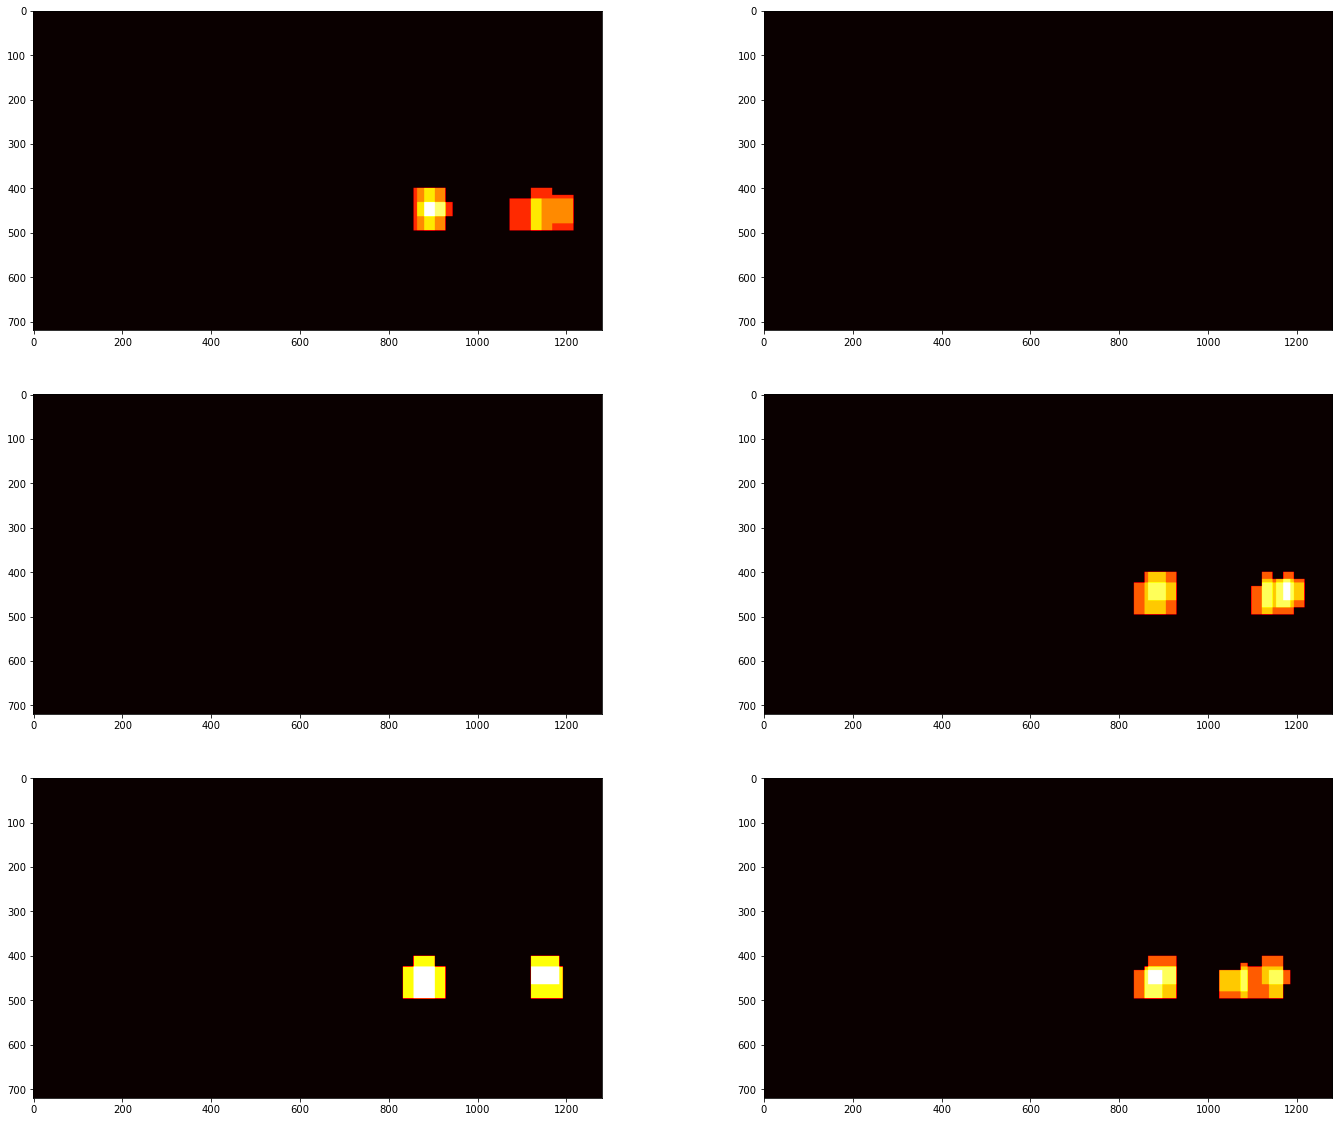

In [25]:
visualize_images(heatmap_images, 2, "Heatmap", cmap="hot")

In [26]:
def find_vehicles(image):
    global prev_labels, prev_rects

    rectangles = get_rectangles(image)
    if not rectangles or len(rectangles) == 0:
        return image

    heatmap_image = np.zeros_like(image[:, :, 0])
    heatmap_image = add_heat(heatmap_image, rectangles)
    heatmap_image = apply_threshold(heatmap_image, 2)
    labels = label(heatmap_image)
    rectangles, result = draw_labeled_bboxes(image, labels)
    # result = draw_boxes(image,rectangles)
    prev_rects = rectangles.copy()
    prev_labels = labels

    return result

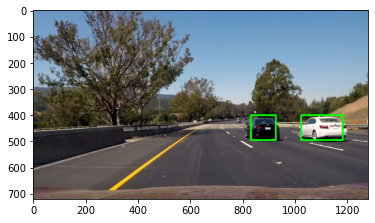

In [27]:
image = plt.imread('./test_images/test6.jpg')
result = find_vehicles(image)
plt.imshow(result)